In [ ]:
# requirement
!pip install sbi

In [ ]:
# !pip install numpyro

In [ ]:
#!pip install --upgrade numpy xarray arviz packaging

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# general
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from tqdm import tqdm
from scipy.stats import binom
import seaborn as sns
from sklearn.neighbors import KernelDensity

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torch.distributions import Distribution
from tqdm import tqdm, trange

# Numpyro
# import numpyro
# import numpyro.distributions as npdist
# import random as rnd
# from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
# from numpyro.diagnostics import hpdi

# numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

#SBI
from sbi.inference import simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

# # check versions
# print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

# code agnostic device
device="cuda" if torch.cuda.is_available() else "cpu"

0.4.23
2.1.0+cpu-cxx11-abi
3.10.12


In [ ]:
#@title requirements
try:
  from utils import install_packages
except:
  # Colab
  !git clone https://github.com/mackelab/simformer.git
  from simformer.example.utils import install_packages
  from google.colab import output
  output.enable_custom_widget_manager()

install_packages()  # install required packages

In [ ]:
# Jax version 0.4.23
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from functools import partial
from typing import Tuple, List, Optional

# Some small helper functions
from probjax.distributions.sde import VESDE
import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions import Empirical, Independent
from scoresbibm.utils.plot import use_style
from sbi.analysis import pairplot
import numpy as np
jax.devices() # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info


# Simple SIR model:
\begin{align*}
\frac{dS}{dt} &= -\beta \frac{S I}{N}, \\
\frac{dI}{dt} &= \beta \frac{S I}{N} - \gamma I, \\
\frac{dR}{dt} &= \gamma I.
\end{align*}
Observasion model:
$$y(t)\sim NegBin(I(t), ϕ)\ ,\quad where\  \phi\ is\ the\ overdispertion$$

In [ ]:
#@title Integration of SIR using Euler Method (faster)
def SIRModel(beta,gamma,T=14):
  # Convert parameters to PyTorch tensors
  S = torch.tensor([S0], dtype=torch.float32)
  I = torch.tensor([I0], dtype=torch.float32)
  R = torch.tensor([R0], dtype=torch.float32)

  # Initialize arrays to store results
  t = torch.arange(0, T, dt)
  S_values = torch.zeros(len(t))
  I_values = torch.zeros(len(t))
  R_values = torch.zeros(len(t))

  # Set initial values
  S_values[0] = S
  I_values[0] = I
  R_values[0] = R

  # Euler's method for numerical integration using PyTorch
  for i in range(1, len(t)):
      dSdt = -beta * S * I / N
      dIdt = beta * S * I / N - gamma * I
      dRdt = gamma * I

      S = S + dSdt * dt
      I = I + dIdt * dt
      R = R + dRdt * dt
      S_values[i] = S
      I_values[i] = I
      R_values[i] = R
  return S_values,I_values,R_values


In [ ]:
#@title test
N = 763             # Total population
I0 = 1              # Initial number of infected individuals
R0 = 0              # Initial number of recovered individuals
S0 = N - I0 - R0
dt = 0.2

S_values,I_values,R_values=SIRModel(beta=2.4,gamma=0.3,T=14)
t = torch.arange(0, 14, 0.2)
# Convert results back to numpy for plotting
S_values = S_values.numpy()
I_values = I_values.numpy()
R_values = R_values.numpy()

# Get the integer part of the tensor
integers = t[t == t.floor()]             # Assume the observe #infected is report per day
# Get the index positions of the integer values
torch.manual_seed(3)
indices = torch.where(t == t.floor())[0]
observation_model=dist.NegativeBinomial(total_count=torch.tensor(I_values), probs=0.52).sample()
y_obs=observation_model[indices]


def plott():
  # Plot the results
  plt.figure(figsize=(6,4))
  #plt.plot(t.numpy(), S_values, 'b', label='Susceptible')
  plt.plot(t.numpy(), I_values, color="red", label='Infected $I(t)$')
  plt.scatter(t[indices], y_obs, color="black", marker='x',label='Observed')
  #plt.plot(t.numpy(), R_values, 'g', label='Recovered')
  plt.xlabel('Days (t)')
  plt.ylabel('Populations')
  plt.title('SIR epidemic trajectory : $\\beta=2.4$, $\\gamma=0.3$, $\\phi=0.52$ ')
  plt.legend()
  plt.grid(True)
  plt.show()

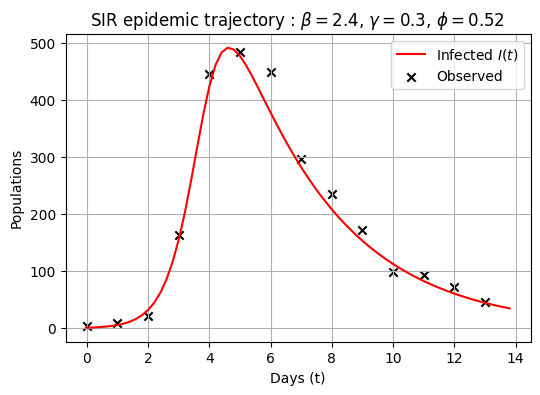

In [ ]:
plott()

In [ ]:
#@title Define Model simulator  and Prior over params (3 params): target I(t)
class CustomPrior(Distribution):
    def __init__(self,mean1, scale1,mean2,scale2,rate): #low_r,high_r
        super().__init__()
        self.beta_dist1 = dist.Normal(mean1,scale1)
        self.gamma_dist2=dist.Normal(mean2,scale2)
        self.disp_dist3=dist.Exponential(rate)
        #self.disp_dist3=dist.Uniform(low=low_r,high=high_r)

    def sample(self, sample_shape=torch.Size()):
        sample1=torch.abs(self.beta_dist1.sample(sample_shape)).unsqueeze(-1)   # troncatedNormal prior
        sample2=torch.abs(self.gamma_dist2.sample(sample_shape)).unsqueeze(-1)  # troncatedNormal prior
        sample3=self.disp_dist3.sample(sample_shape).unsqueeze(-1)              # exponential prior
        return torch.cat([sample1, sample2, sample3], dim=-1)

    def log_prob(self):
      pass

### Instantiate the prior
prior=CustomPrior(mean1=2,scale1=1, mean2=0.2,scale2=0.6,rate=5) #rate=5


### Observational_Model ()

# Initialization
N = 763             # Total population
I0 = 1              # Initial number of infected individuals
R0 = 0              # Initial number of recovered individuals
S0 = N - I0 - R0    # Initial number of susceptible individuals
#T = 160            # Number of days (period) to simulate
dt = 0.5            # Time step (in days)
N = torch.tensor(N, dtype=torch.float32)

def simulator_Model(theta):
  if theta.dim()==1:
    beta=theta[0][0]
    gamma=theta[0][1]
    phi=theta[0][2]
  else:
    beta=theta[0][0]
    gamma=theta[0][1]
    phi=theta[0][2]
  ## Simulate T-1 tiemsteps
  # time points (in days)
  # T=torch.randint(T_min,T_max,(1,)).squeeze()
  S, I, R = SIRModel(beta, gamma,T=14)
  I=torch.nan_to_num(torch.clamp(I, min=0, max=N), nan=0.0)
  phi=torch.clamp(phi,0,0.99)
  I_obs=dist.NegativeBinomial(total_count=I, probs=phi).sample()
  return I_obs.unsqueeze(-1).unsqueeze(0)                        # output time serie with one feature "#Infected"


In [ ]:
#@title old
def simulator_Model(theta):

  beta=theta[0][0]
  gamma=theta[0][1]
  phi=theta[0][2]
  ## Simulate T-1 tiemsteps
  # time points (in days)
  #T=torch.randint(T_min,T_max,(1,)).squeeze()
  t = torch.arange(1, 15).type(torch.float)
  # Create the SIR model instance
  sir_model = SIRModel(beta, gamma,N)
  sir_model.to(device)
# Integrate the SIR equations over the time grid, t
  solution = odeint(sir_model, y0, t)
  S, I, R = solution.T
  I=torch.clamp(I, min=0, max=N)
  phi=torch.clamp(phi,0,0.99)
  I_obs=dist.NegativeBinomial(total_count=I, probs=phi).sample()
  return torch.cat([I_obs.unsqueeze(-1),R.unsqueeze(-1)], dim=-1).unsqueeze(0) # output time serie with 2 features "#infected, #Recover"


In [ ]:
# #@title Simulate synthetic data for training
# theta, y = simulate_for_sbi( simulator_Model, proposal=prior, num_simulations=4000)

# Approach: BayesFlow with Conditionnal Invertible Neural Networks
Starting with a simple base distributions $p(z)$ and applying a series of diffeomorphism ( differentiable bijection),
fit a flow-based model $\hat{p}(\theta | y)$ conditioned
on $y$ to the generated data set $\{(\theta_n , y_n )\}_
n $ in order to approximate the posterior $p(\theta | y).$
## general architecture:

![image](/content/sample_data/general_arch_cINN.png)

## cINN type: Sequence of affine coupling layers $f_\phi$
$f_\phi=f_1of_2o...of_K$

**$f_k$ module**:   
  * Each coupling layer splits its input $\mathbf{x} \in \mathbb{R}^D$ into two halves $\mathbf{x}_1, \mathbf{x}_2 \in \mathbb{R}^{D/2}$.
  *  Each half is subjected to an affine transformation, producing outputs $\mathbf{z}_1, \mathbf{z}_2 \in \mathbb{R}^{D/2}$.
  * The affine coefficients are computed by standard fully connected networks.
  * The scale $\mathbf{s}_{k} \in \mathbb{R}^+$ and shift $\mathbf{t}_{k} \in \mathbb{R}^{D/2}$ are derived from the other half’s data.

    *Forward computation*:
    $$z=f_k(x,y)⟺ z_1 = x_1 \odot s_k(x_2,y) + t_k(x_2,y), \quad z_2 = x_2 $$
    *Inverse computation*: $$x=f_k^{-1}(z,y) ⟺ x_1=(z_1-t_k(z_2,y))\oslash s_k(z_2) ,\quad  x_2=z_2$$


**Entire structure:**
* concatenate many coupling layers
* Alternate with and orthogonal layer $Q$ ( Random permutation): shuffle the coordinate around between coupling layer to make sure that the skip cordinate is not always the same set of parameter.

## Conditioning network architecture $g_{\eta}$
Designed to process time series data with multiple features and summarize the information into a lower-dimensional representation (a summary).
Components:
  1. 1D Convolutional Layers: extracts relevant features from the time series data while preserving the
temporal structure of the data,.
  2. LSTM Layers: Capture temporal dependencies and summarize the extracted features into a fixed-size summary  vector.

### Training :
Estimated conditional density $\hat{p}(\theta | y)$ expressed via change-of variable formula :
$$z=f_{\phi}\big(\theta,g_{\eta}(y)\big)\quad s.t.\ \ p(z)=\mathcal{N}(0,\mathbb{I})$$
$$ \hat{p}(\theta | y)=p_z\big(z=f_{\phi}\big(\theta,g_{\eta}(y)\big)\big)\mid \nabla_\phi f_{\phi}\big(\theta,g_{\eta}(y)\big)\mid$$

Trained with the Maximum likelihood loss (has especially simple form when $p(z)$ is standard normal) :
\begin{align*}
\mathcal{L}(\phi,\eta)=-\log  \hat{p}(\theta | y)&=-\log p_z\big(z=f_{\phi}\big(\theta,g_{\eta}(y)\big)\big)-\log \mid \nabla_\phi f_{\phi}\big(\theta,g_{\eta}(y)\big)\mid \\
&=\frac{D}{2}\log (2\pi)+\frac{1}{2}\mid\mid f_{\phi}\big(\theta,g_{\eta}(y)\big) \mid\mid_2^2-\sum_{l=1}^{L}sum\big(\log(S_{\phi,l}(\theta_{l2},g_{\eta}(y)\big)\big)\\
& with\ S_{\phi,l}(\theta_{l2},g_{\eta}(y)\big)\ the\ multiplier\ at\ coupling\ layer\ l.
\end{align*}

## Inference:
Since $ f_\phi$ is invertible (given a time series $\hat{y}_{1:T}$), we get a generative model for free:

$\hat{\theta} \sim \hat{p}(\theta \mid \hat{y}_{1:T}) \quad \Leftrightarrow \quad z \sim \mathcal{N}(0, \mathbb{I})\ \ and \ \theta = f_\theta^{-1}\big(z;g_{\eta}(\hat{y}_{1:T})\big) $.

## First comments:
* Expensive one-time (upfront) training of $p_{\phi,\eta}$ using simulated data.
* Each inference query $\hat{p}_{\phi,\eta}(\theta \mid \mathbf{y}_{\text{obs}})$ (for different $\mathbf{y}_{\text{obs}}$) is then cheap $\Rightarrow$ Training effort quickly amortizes over multiple cheap queries.


*Ref. RealNVP [Dinh et al. 2017]*

*Ardizzone et al. “Guided Image Generation with Conditional Invertible Neural Networks”, arXiv 2019*

In [ ]:
#model args
input_dim=3   # input dimension ( 3 hidden params)
num_layers=5  # number of coupling layers
n_summary=7   # conditioning feature vector dimension
n_features=1  # number of time series future ( only #infected)
n_layers=2    # number of LSTM module

In [ ]:
# ortogonal matrix
def permutation_matrix(n):
    # Create an identity matrix of size n
    P = torch.eye(n, dtype=torch.float32)
    # Randomly permute the rows of the identity matrix
    P = P[torch.randperm(n), :]
    return P

In [ ]:
#@title permutation layer
class PermutationLayer(nn.Module):
    def __init__(self, input_dim,Q):
        super().__init__()
        self.input_dim = input_dim
        # Create a fixed permutation matrix
        self.permutation = nn.Parameter(Q, requires_grad=False)

    def forward(self, x):
        # Apply the permutation matrix Q to the input
        return torch.matmul(x, self.permutation)

    def inverse(self, z):
        # Apply the inverse permutation (transpose of the permutation matrix)
        return  torch.matmul(z,self.permutation.t())

In [ ]:
#@title coupling layer module
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, input_dim // 2),
            nn.Tanh()  # To keep scale between -1 and 1
        )
        self.shift_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, input_dim // 2)
        )

    def forward(self, x, condition):
        x1, x2 = torch.chunk(x, 2, dim=1)
        # Concatenate x2 with the conditioning input
        x2_conditioned = torch.cat([x2, condition], dim=1)
        scale = self.scale_net(x2_conditioned)
        shift = self.shift_net(x2_conditioned)
        z1 = x1 * torch.exp(scale) + shift
        z2 = x2
        log_det_jacobian = scale.sum(dim=-1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det_jacobian

    def inverse(self, z, condition):
        z1, z2 = torch.chunk(z, 2, dim=1)
        # Concatenate z2 with the conditioning input
        z2_conditioned = torch.cat([z2, condition], dim=1)
        scale = self.scale_net(z2_conditioned)
        shift = self.shift_net(z2_conditioned)
        x1 = (z1 - shift) * torch.exp(-scale)
        x2 = z2
        #log_det_jacobian = -scale.sum(dim=-1)
        x = torch.cat([x1, x2], dim=1)
        return x #,log_det_jacobian


In [ ]:

#@title Conditioning  Network ( S(y) )

## The conditional Network Here is a fully connected layer

class ConditioningNetwork(nn.Module):
    def __init__(self, n_summary, n_features, n_layers):
        super(ConditioningNetwork, self).__init__()

        # Convolutional layers using nn.Sequential
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=n_summary, kernel_size=3, stride=1, padding=2),  # Padding changed to 'same' equivalent
            nn.ReLU(),
            nn.Conv1d(in_channels=n_summary, out_channels=n_summary*2, kernel_size=2, stride=1, padding=1),  # Padding changed to 'same' equivalent
            nn.ReLU(),
            nn.Conv1d(in_channels=n_summary*2, out_channels=n_summary*3, kernel_size=1, stride=1, padding=0),
            nn.ReLU()
        )

        # LSTM layers with n_layers argument
        self.lstm = nn.LSTM(input_size=n_summary*3, hidden_size=n_summary, num_layers=n_layers, batch_first=True)

    def forward(self, x):
        """x is a timeseries of dimensions [batch_size, timestamps, n_features]"""

        # Permute to match PyTorch's expected input for Conv1d: [batch_size, n_features, timestamps]
        x = x.permute(0, 2, 1)

        # Apply the convolutional layers
        out = self.conv(x)

        # Permute back to [B, timestamps, n_features] before LSTM
        out = out.permute(0, 2, 1)

        # Apply the LSTM layers
        out, _ = self.lstm(out)

        # Return the last output of the LSTM for the final summary
        return out[:, -1, :]


In [ ]:
#@title the cINN
class ConditionalInvertibleNN2(nn.Module):
    def __init__(self, input_dim,num_layers,Q,n_summary, n_features, n_layers):
        super().__init__()
        self.conditioning_network = ConditioningNetwork(n_summary, n_features, n_layers=2)
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(AffineCouplingLayer(input_dim,n_summary ))
            self.layers.append(PermutationLayer(input_dim,Q))

    def forward(self, x, condition):
        condition_features = self.conditioning_network(condition)
        log_det_jacobian_total = 0
        for layer in self.layers[:-1]:
            if isinstance(layer, AffineCouplingLayer):
                x, log_det_jacobian = layer(x, condition_features)
            else:
                x = layer(x)
            log_det_jacobian_total += log_det_jacobian
        return x, log_det_jacobian_total

    def inverse(self, z, condition):
        condition_features = self.conditioning_network(condition)
        log_det_jacobian_total = 0
        for layer in reversed(self.layers[:-1]):
            if isinstance(layer, AffineCouplingLayer):
                z= layer.inverse(z, condition_features)
            else:
                z = layer.inverse(z)
            #log_det_jacobian_total += log_det_jacobian
        return z #,log_det_jacobian_total


In [ ]:
#@title define the Loss function ( Negative log Likelihood ) & Latent space prior ( Standard Gaussian)
# Loss
class NLLLoss(nn.Module):
    def __init__(self):
        super().__init__()
       # base distribution
       # Typically a standard normal distribution

    def forward(self, z, log_det_jacobian):
      #log_prob=self.dist.log_prob(z)
      log_prob = -0.5 * z.pow(2).sum(dim=-1) - 0.5 * z.size(1) * torch.log(torch.tensor(2 * torch.pi))
      nll = - (log_prob+ log_det_jacobian)
      return nll.mean()

In [ ]:
#@title  prepare for training

def train_cINN(x,cond, model, optimizer, num_epochs):
    train_loss=[]
    model.train()
    for epoch in range(num_epochs):
      #for x, cond in data_loader:

      # Forward pass
      z, log_det_jacobian = model(x.to(device), cond.to(device))
      # calculate the loss
      loss=loss_fn(z,log_det_jacobian)
      optimizer.zero_grad()
      # Backpropagation
      loss.backward()
      # Optimize step
      optimizer.step()
      train_loss.append(loss)
      if epoch % 100==0:
        print(f"Epoch: {epoch} | Loss: {loss}")
    return train_loss


In [ ]:
#model.load_state_dict(torch.load("/content/sir_model_it3.pth"))

<All keys matched successfully>

In [ ]:
#@title Learned Posterior
class LearnPosterior(Distribution):
    def __init__(self,y_o,base_dist,model,device):
        super().__init__()
        self.y=y_o # conditioning variable
        self.P_z=base_dist # base distribution
        self.model=model # trained model ( cINN )
        self.device= device # device
    def sample(self,sample_shape=torch.Size()):
        self.model.eval()
        with torch.inference_mode():
          n=sample_shape[0]
          f_post=self.model.inverse(self.P_z.sample((n,)).to(self.device),self.y.unsqueeze(0).repeat(n,1,1).to(self.device))
          if self.device=="cuda":
            f_post=f_post.cpu()
        return f_post

    def sample_batch(self,y_batch):
      self.model.eval()
      with torch.inference_mode():
          n=y_batch.shape[0]
          theta_samples=self.model.inverse(self.P_z.sample((n,)).to(self.device),y_batch.to(self.device))
          if self.device=="cuda":
            theta_samples=theta_samples.cpu()
      return theta_samples


## Use .sample() method to sample from the learned posterior
#Learned_posterior=LearnPosterior(y_o,P_z,model,device)

In [ ]:
def Post_predictive(theta):
  if theta.dim()==1:
    beta=theta[0][0]
    gamma=theta[0][1]
    phi=theta[0][2]
  else:
    beta=theta[0][0]
    gamma=theta[0][1]
    phi=theta[0][2]
  ## Simulate T-1 tiemsteps
  # time points (in days)
  # T=torch.randint(T_min,T_max,(1,)).squeeze()
  S, I, R = SIRModel(beta, gamma,T=14)
  I=torch.nan_to_num(torch.clamp(I, min=0, max=N), nan=0.0)
  phi=torch.clamp(phi,0,0.99)
  I_obs=dist.NegativeBinomial(total_count=I, probs=phi).sample()
  return I_obs.unsqueeze(0)

In [ ]:
#@title plotters
#dt=1
T=14

def plotter1(n_samples=500,dt=0.5,i=1):
  x=np.array(t[indices])
  tt = torch.arange(0, T, dt)

  theta_post, y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=n_samples)
  predictions=y_pred.numpy()

  #plot
  mean_post_pred = np.mean(predictions, axis=0)
  hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  #plt.plot(x, gp_draw, label="ground truth", color="orange")
  plt.scatter(x,np.array(y_obs), color="black", label="observed",marker='x', s=60)
  plt.plot(tt, mean_post_pred, label="mean prediction")
  plt.legend()
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(tt, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.title("Posterior predictive")
  plt.legend(fontsize=7)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(tt, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")


#@title plotter function
def plotter2(n_samples=500,dt=0.5,i=1):
  x=np.array(t[indices])
  tt = torch.arange(0, T, dt)
  theta_post, y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=n_samples)
  predictions=y_pred.numpy()

  #plot
  mean_post_pred = np.median(predictions, axis=0)
  hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  #plt.plot(x, gp_draw, label="ground truth", color="orange")
  plt.scatter(x,np.array(y_obs), color="black", label="observed",marker='x', s=60)
  plt.plot(tt, mean_post_pred, label="posterior predictive mean")
  #plt.legend()
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(tt, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.xlabel('Days (t)')
  plt.ylabel('#infected')
  plt.title('predited trajectory $I(t)$')
  plt.legend(fontsize=7)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  #plt.fill_between(tt, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")


In [ ]:
#@title Setup

dt=0.5  # time step
input_dim=3      #  input dimension
num_layers=8 # number of stacked coupling layer
n_summary=5  #  cond_features  dimension (summary)
n_features=1     # 1 times serie feature ( Infected )
n_layers=2     # number of LSTM module


# Latent space prior : P(z)
mean=torch.zeros(input_dim)
Cov=torch.eye(input_dim)
P_z =dist.MultivariateNormal(mean,Cov)                           # base distribution ( standard normal

prior=CustomPrior(mean1=2,scale1=0.5, mean2=0.2,scale2=0.4,rate=6)  #Instantiate the prior

Q=permutation_matrix(input_dim)                                                                       #permutation matrix ( orthogonal )
model = ConditionalInvertibleNN2(input_dim,num_layers,Q,n_summary, n_features, n_layers).to(device)   #instantiate the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)                                             # define the optimizer
loss_fn=NLLLoss().to(device)                                                                          # instantiate the loss function

#Observed data
y_o=y_obs.unsqueeze(1)


In [ ]:
#@title Training
#fig = plt.figure(figsize=(16,8))
#fig = plt.figure(figsize=(6,5))
Round=1
proposal=prior         # start with the original proposal (prior)
start_time = time.time() # Start time

for i in tqdm(range(1,Round+1)):
  theta, y = simulate_for_sbi(simulator_Model, proposal=prior, num_simulations=1500)     # simulate synthetic data for training
  train_loss=train_cINN(theta.to(device),y.to(device), model, optimizer,num_epochs=1700) # train
  Learned_posterior=LearnPosterior(y_o,P_z,model,device)                                 # Learned posterior
  # fig.add_subplot(1, 1, i)
  # plotter2(500,dt,i)                                                                        # visualize posterior predictive
  proposal=Learned_posterior
                                                                                        # use the learned posterior as the prior for the next round
import time
end_time = time.time()  # End time
elapsed_time = end_time - start_time  #running time

# Print the running time
print(f"Running time: {elapsed_time:.4f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch: 0 | Loss: 6.818265438079834
Epoch: 100 | Loss: 3.6713457107543945
Epoch: 200 | Loss: 3.0869438648223877
Epoch: 300 | Loss: 2.656033515930176
Epoch: 400 | Loss: 1.8454879522323608
Epoch: 500 | Loss: 1.1120911836624146
Epoch: 600 | Loss: 0.7879539132118225
Epoch: 700 | Loss: 0.5774146914482117
Epoch: 800 | Loss: 0.35914090275764465
Epoch: 900 | Loss: 0.02162782847881317
Epoch: 1000 | Loss: -0.2159745693206787
Epoch: 1100 | Loss: -0.3930431008338928
Epoch: 1200 | Loss: -0.5650984048843384
Epoch: 1300 | Loss: -0.7377983331680298
Epoch: 1400 | Loss: -0.9122136831283569
Epoch: 1500 | Loss: -1.08610200881958
Epoch: 1600 | Loss: -1.207827091217041


100%|██████████| 1/1 [00:39<00:00, 39.93s/it]

Running time: 39.9397 seconds


  0%|          | 0/500 [00:00<?, ?it/s]

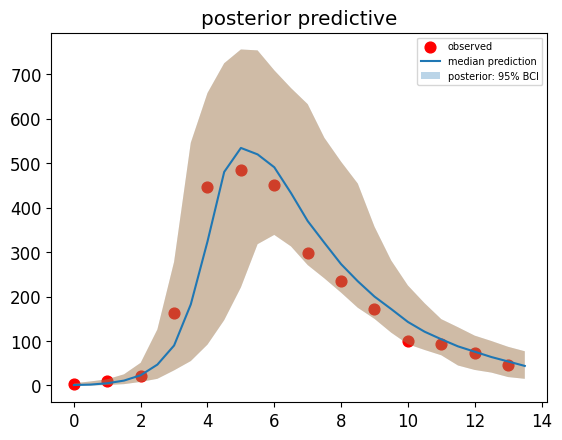

In [ ]:
plotter2(5000,dt=0.5)

In [ ]:
#@title Training
#fig = plt.figure(figsize=(16,8))
#fig = plt.figure(figsize=(6,5))
Round=1
proposal=prior         # start with the original proposal (prior)
start_time = time.time() # Start time

for i in tqdm(range(1,Round+1)):
  theta, y = simulate_for_sbi(simulator_Model, proposal=prior, num_simulations=3000)     # simulate synthetic data for training
  train_loss=train_cINN(theta.to(device),y.to(device), model, optimizer,num_epochs=1900) # train
  Learned_posterior=LearnPosterior(y_o,P_z,model,device)                                 # Learned posterior
  # fig.add_subplot(1, 1, i)
  # plotter2(500,dt,i)                                                                        # visualize posterior predictive
  proposal=Learned_posterior
                                                                                        # use the learned posterior as the prior for the next round
import time
end_time = time.time()  # End time
elapsed_time = end_time - start_time  #running time

# Print the running time
print(f"Running time: {elapsed_time:.4f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 4.650435924530029
Epoch: 100 | Loss: 2.844277858734131
Epoch: 200 | Loss: 1.1017824411392212
Epoch: 300 | Loss: 0.19359317421913147
Epoch: 400 | Loss: -0.5621904730796814
Epoch: 500 | Loss: -0.9989413022994995
Epoch: 600 | Loss: -1.2792569398880005
Epoch: 700 | Loss: -1.4923162460327148
Epoch: 800 | Loss: -1.6941123008728027
Epoch: 900 | Loss: -2.1061437129974365
Epoch: 1000 | Loss: -2.6034679412841797
Epoch: 1100 | Loss: -2.9211089611053467
Epoch: 1200 | Loss: -3.1623661518096924
Epoch: 1300 | Loss: -3.378253936767578
Epoch: 1400 | Loss: -3.546250820159912
Epoch: 1500 | Loss: -3.6751914024353027
Epoch: 1600 | Loss: -3.781832695007324
Epoch: 1700 | Loss: -3.8839290142059326
Epoch: 1800 | Loss: -3.9480226039886475


100%|██████████| 1/1 [00:53<00:00, 53.04s/it]

Running time: 53.0495 seconds


In [ ]:
Learned_posterior=LearnPosterior(y_o,P_z,model2,device)

  0%|          | 0/2000 [00:00<?, ?it/s]

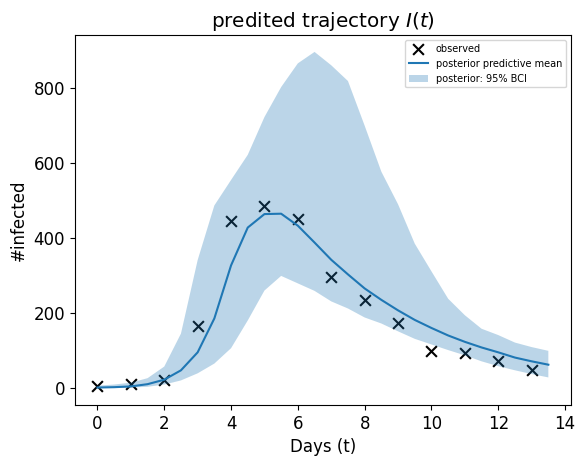

In [ ]:
plotter2(2000,dt=0.5)

  0%|          | 0/1000 [00:00<?, ?it/s]

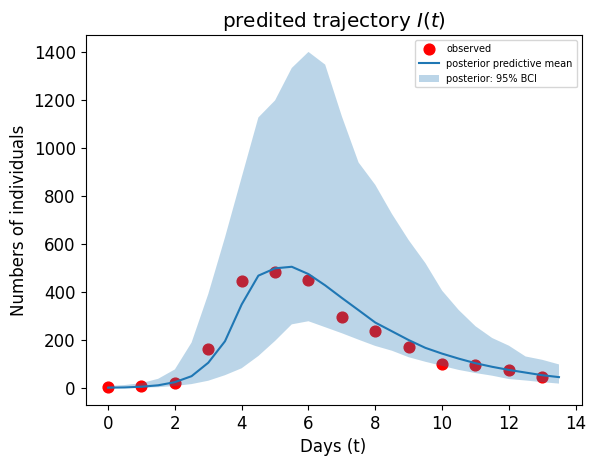

In [ ]:
plotter2(1000,dt=0.5)

Text(0.5, 1.0, 'training loss')

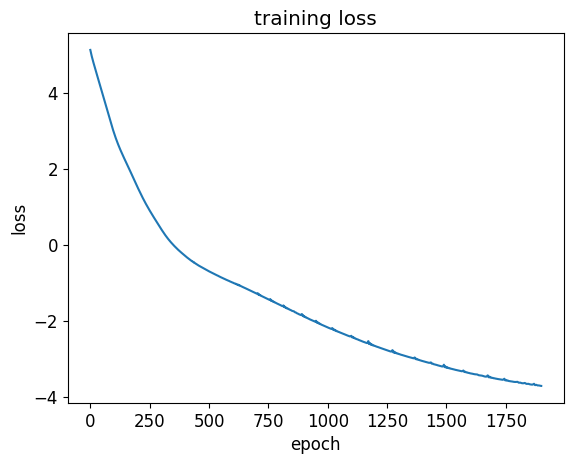

In [ ]:
train_loss=torch.tensor(train_loss)
plt.plot(np.arange(len(train_loss)),train_loss.numpy())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training loss")

In [ ]:
torch.save(model, 'SIR_inf_recent2.pth')

In [ ]:
# Step 1: Load the entire model
model2= torch.load('/content/SIR_inf_recent2.pth')

<ipython-input-164-b93543231f39>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2= torch.load('/content/SIR_inf_recent2.pth')


In [ ]:
#torch.save(model.state_dict(), 'sir_model_best.pth')

## Diagnostic Analysis

In [ ]:
#posterior samples
posterior_samples,y_pred = simulate_for_sbi(Post_predictive, proposal=Learned_posterior, num_simulations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

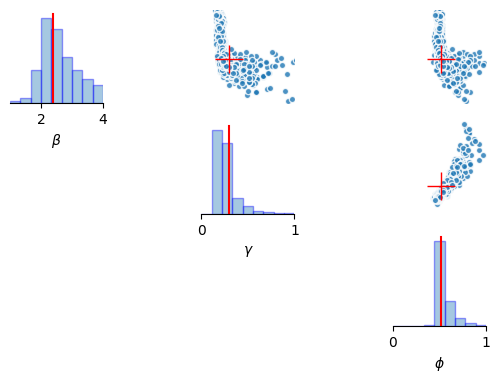

In [ ]:
#@title Posterior density analysis
#observed data:
theta_o = torch.tensor([2.4,0.3,0.52]).unsqueeze(0)

_ = analysis.pairplot(
    posterior_samples,
    limits=[[1,4],[0,1],[0,1]],
    figsize=(7, 4),
    diag="hist",
    upper="scatter",
    diag_kwargs={
        "mpl_kwargs": {
            "bins": 10,
            "color": 'tab:blue',
            "edgecolor": 'blue',
            "linewidth": 1,
            "alpha": 0.4,
            "histtype": "bar",
            "fill":True,
        }
    },
    upper_kwargs=[
        {"mpl_kwargs": {"color": 'tab:blue', "s": 20, "alpha": 0.8}},

    ],
    points=theta_o,
    fig_kwargs={
        #"points_labels": [r"$\theta_o$"],
        "legend": False,
        "points_colors": ["red"],
        "points_offdiag": {"marker": "+", "markersize": 20},
        "despine": {"offset": 0},
    },
      labels=[r"$\beta$", r"$\gamma$", r"$\phi$"],

)

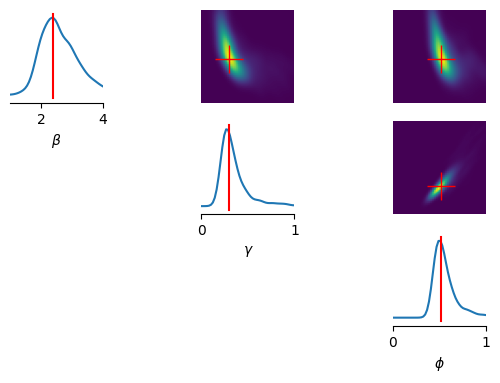

In [ ]:
from pickle import TRUE
#@title kde
fig, ax = analysis.pairplot(
    samples=posterior_samples,
   limits=[[1,4],[0,1],[0,1]],
    upper=["kde"],
    diag=["kde"],
    figsize=(7, 4),
     points=theta_o,
    fig_kwargs={
        #"points_labels": [r"$\theta_0$"],
        #"legend": True,
        "points_colors": ["red"],
        "points_offdiag": {"marker": "+", "markersize": 20},
        "despine": {"offset": 0},
    },
    labels=[r"$\beta$", r"$\gamma$", r"$\phi$"],
)

In [ ]:
#@title Full Marginal posterior

def estimate_map(samples):

    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i

def plot_posteriors_state( n_samples=1000, figsize=(8, 3), dpi=150,
                          font_size=12, bins=30, map_samples=500, filename=None):
    """Plots full posteriors for each state."""

    # Plot settings
    plt.rcParams['font.size'] = font_size


    samples=np.array(Learned_posterior.sample((n_samples,)))
    prior_samples = np.array(prior.sample((n_samples,)))


    f, ax = plt.subplots(1, 3, figsize=figsize)
    for i in range(samples.shape[1]):


        sns.histplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior')
        sns.histplot(prior_samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='gray',label='Prior', alpha=0.3)

        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(true_params[i], color='black', linestyle='dashed',label=param_id[i]) # true_params[i]
        ax.flat[i].set_title(param_names_str[i] + ' (' + param_names[i] + ')', pad=6, fontsize=14)
        ax.flat[i].set_ylim([0, ax.flat[i].get_ylim()[1]])

        align = 'left'
        xx = 0.73
        med = np.median(samples[:, i])
        MAP = estimate_map(samples[:map_samples, i])
        ax.flat[i].text(xx, 0.85, r'$MAP={:.2f}$'.format(MAP),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        ax.flat[i].text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)

        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])

    f.tight_layout()
    f.subplots_adjust(bottom=0.07)
    ax.flat[samples.shape[1]-1].legend(fontsize='small')
     # Save if specified
    # if filename is not None:
    #     f.savefig("figures/{}.png".format(filename), dpi=dpi,
    #               bbox_extra_artists=(lg,), bbox_inches='tight')

param_names_str = ['contact rate','average recovery rate','overdispersion']
param_names=['$\\beta$','$\gamma$','$\phi$']
param_id=['true $\\beta$','true $\gamma$','$true$']
true_params = np.array([2.4,0.3,0.52])

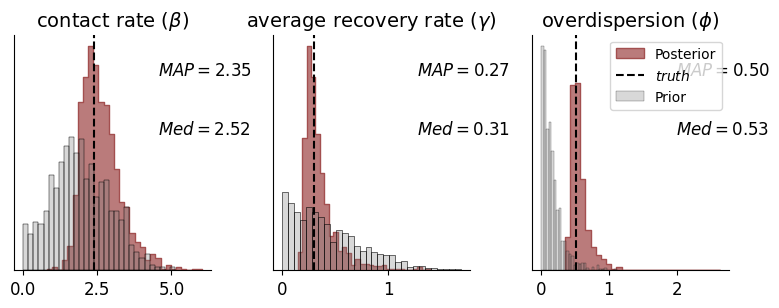

In [ ]:
plot_posteriors_state()

### Posterior predictive Check (PPC)
A PPC compares data (time series) $\ y_{pp}$ generated using the parameters $\ \theta_{posterior}=\{ \beta,\gamma,\phi\}$ sampled from the posterior with the observed data $\ y_{obs}$. The general concept is that -if the inference is correct,$\ y_{obs}$ should be within the support of  $\ y_{pp}$ or say differently, the posterior predictive samples should cluster around the observation $\ y_{obs}$.

### Uncertainty Callibration ( SBC)
 we want to check wether the variances of the posterior are balanced.

**Simulation based Callibration** ranks of ground truth parameters under the inferred posterior samples should follow a uniform distribution.
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

In [ ]:
n_sbc_samples =300 #200  #number of sbc runs
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas_test,ys= simulate_for_sbi(simulator_Model, proposal=prior, num_simulations=n_sbc_samples)
thetas_test=np.array(thetas_test)

n_post_samples=2000 #numper of posterior samples per data y_i
thetas_samples=[]
for s in range(n_post_samples):
  thetas_samples.append(np.array(Learned_posterior.sample_batch(ys)))

thetas_samples=np.array(thetas_samples)

  0%|          | 0/300 [00:00<?, ?it/s]

<ipython-input-93-8afcbd5f3144>:28: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f',


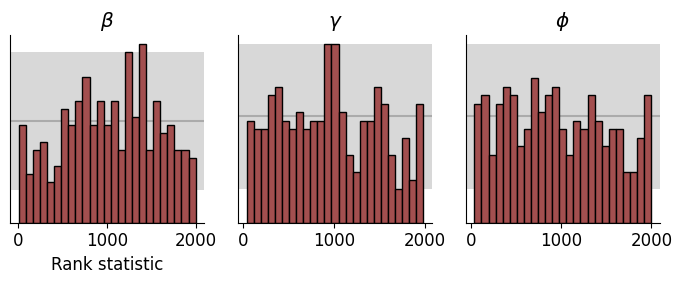

In [ ]:
plot_sbc(thetas_samples,thetas_test , param_names=["$\\beta$","$\gamma$","$\phi$"])

In [ ]:
#@title Ranks versus Uniform distribution
def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(7,3), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])


    f, axarr = plt.subplots(1, 3, figsize=figsize)
    axarr = axarr.flat

    # Compute ranks (using broadcasting)
    ranks = np.sum(theta_samples < theta_test, axis=0)

    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)

        sns.distplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f',
                         hist_kws=dict(edgecolor="k", linewidth=1,alpha=1.), bins=bins)

        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])

    f.tight_layout()

    # Show, if specified
    if show:
        plt.show()

    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300)

# SEIR with non parametric parameter ( infinite-dimentional params )

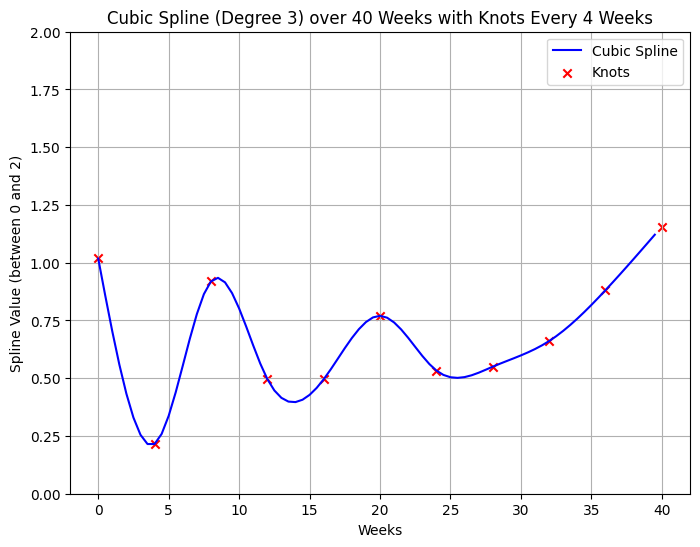

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

np.random.seed(44) #44

# Step 1: Define the x values (weeks) over the interval [0, 40]
weeks = np.arange(0, 40, 0.5)  # 40 weeks

# Step 2: Define knot points every 4 weeks
knots = np.arange(0, 41, 4)  # Knots at 0, 4, 8, ..., 40

# Step 3: Define random y-values for the knots in the range [0, 2]
y_values = np.random.uniform(0.1, 1.2, size=knots.shape)

# Step 4: Build the cubic spline
spline = CubicSpline(knots, y_values, bc_type='natural')

# Step 5: Evaluate the spline at the points corresponding to the 40 weeks
spline_values = spline(weeks)


# Step 6: Plot the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(weeks, spline_values, label="Cubic Spline", color='b')
plt.scatter(knots, y_values, color='r', marker='x', label='Knots')
plt.title("Cubic Spline (Degree 3) over 40 Weeks with Knots Every 4 Weeks")
plt.xlabel("Weeks")
plt.ylabel("Spline Value (between 0 and 2)")
plt.ylim(0, 2)
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
obs_idx=np.arange(2,80,5)
#obs_idx=np.array([ 2, 9, 19, 30, 42, 52, 62, 72])
obs_idx.shape

(16,)

In [ ]:
import torch
# Parameters
S0 = 990  # Initial susceptible population
E0 = 0    # Initial exposed population
I0 = 5   # Initial infected population
R0 = 0    # Initial recovered population
beta = 0.25  # Transmission rate
gamma = 0.2  # Recovery rate
tau = 0.3    # Incubation rate
max_pop= S0 + E0 + I0 + R0  # Total population
total_time = 40  # Total time to simulate
dt = 0.5  # Time step size
c=14 #14    # contact

def sier_Model(beta, gamma, tau,rho_func, S0=S0, E0=E0, I0=I0, R0=R0, c=c, N=max_pop, total_time=total_time,dt=dt):
    # Initialize state variables
    S = S0
    E = E0
    I = I0
    R = R0

    # Time array
    time_steps = int(total_time / dt)
    S_vals = torch.zeros(time_steps)
    E_vals = torch.zeros(time_steps)
    I_vals = torch.zeros(time_steps)
    R_vals = torch.zeros(time_steps)

    for t in range(time_steps):
        # Calculate current time
        current_time = t * dt

        # Calculate rho(t)
        rho_t = rho_func[t]

        # Store values
        S_vals[t] = S
        E_vals[t] = E
        I_vals[t] = I
        R_vals[t] = R

        # Calculate the derivatives
        dS_dt = -beta * rho_t *c* (S * I / N)
        dE_dt = beta * rho_t * c*(S * I / N) - tau * E
        dI_dt = tau * E - gamma * I
        dR_dt = gamma * I

        # Update states using Euler's method
        S += dS_dt * dt
        E += dE_dt * dt
        I += dI_dt * dt
        R += dR_dt * dt

    return I_vals


# Run simulation
I_vals =sier_Model(beta, gamma, tau,torch.tensor(spline_values))

In [ ]:
torch.manual_seed(43)
observation_model=dist.NegativeBinomial(total_count=I_vals, probs=0.51).sample()
y_obs=observation_model

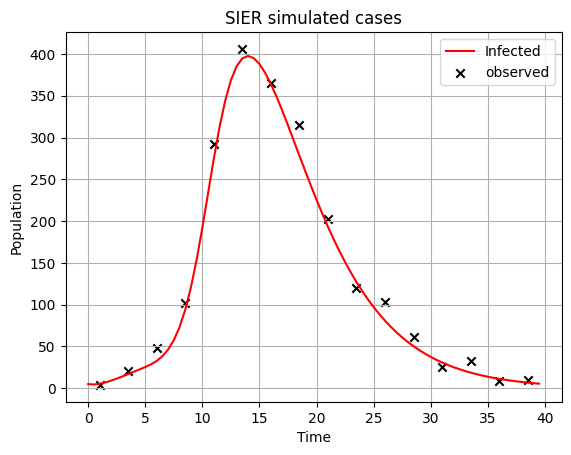

In [ ]:
# Time array for plotting
time_array = torch.arange(0, total_time, dt)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(time_array.numpy(), S_vals.numpy(), label='Susceptible', color='blue')
# plt.plot(time_array.numpy(), E_vals.numpy(), label='Exposed', color='orange')
plt.plot(time_array.numpy(), I_vals.numpy(), label='Infected', color='red')
#plt.plot(time_array.numpy(), R_vals.numpy(), label='Recovered', color='green')
plt.scatter(time_array.numpy()[obs_idx], y_obs.numpy()[obs_idx], marker='x', label='observed', color='black')

plt.title('SIER simulated cases')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_o=np.concatenate([spline_values[obs_idx],np.array(y_obs)[obs_idx]],axis=-1)

In [ ]:
#@title  GP RBK kernel ( pythorch version)
dim = 80  # Number of points along each dimension
x = torch.linspace(0, 50, dim)
def dist_euclid(x, z):
    x = torch.as_tensor(x)
    z = torch.as_tensor(z)
    if len(x.shape) == 1:
        x = x.unsqueeze(1)
    if len(z.shape) == 1:
        z = z.unsqueeze(1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = torch.zeros((n_x, n_z))
    for d in range(m):
        x_d = x[:, d]
        z_d = z[:, d]
        delta += (x_d[:, None] - z_d) ** 2
    return torch.sqrt(delta)

def gp_kernel(ls=5,x=x, z=x,sigma=2.5, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = torch.pow(dist / ls, 2.0)
    k = (sigma ** 2) * torch.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * torch.eye(x.shape[0], device=x.device)
    return k

In [ ]:
#@title Define Model simulator  and Prior over params : target I(t)
class CustomPrior(Distribution):
    def __init__(self,mean1, scale1,mean2,scale2,cov_func): #low_r,high_r
        super().__init__()
        self.beta_dist1 = dist.Normal(mean1,scale1)
        self.gamma_dist2=dist.Normal(mean2,scale2)
        self.tau_dist3=dist.Normal(mean2,scale2)
        self.cov_func=cov_func
        #self.disp_dist3=dist.Uniform(low=low_r,high=high_r)

    def sample(self, sample_shape=torch.Size()):
        sample1=torch.abs(self.beta_dist1.sample(sample_shape)).unsqueeze(-1)   # troncatedNormal prior
        sample2=torch.abs(self.gamma_dist2.sample(sample_shape)).unsqueeze(-1)  # troncatedNormal prior
        sample3=torch.abs(self.tau_dist3.sample(sample_shape)).unsqueeze(-1)   #troncatedNormal prior
        K= self.cov_func()
        dist3 = dist.MultivariateNormal(loc=0.5*torch.ones(K.shape[0]), covariance_matrix=K)
        sample4=dist3.sample(sample_shape)

        return torch.cat([sample1, sample2, sample3, sample4], dim=-1)

    def log_prob(self):
      pass

### Instantiate the prior
prior=CustomPrior(mean1=0.2,scale1=0.6, mean2=0.1,scale2=0.3,cov_func=gp_kernel) #rate=5


### Observational_Model ()

def simulator_Model(theta):
  if theta.dim()==1:
     beta=theta[0][0]
  #   gamma=theta[0][1]
  #   phi=theta[0][2]
  # else:
  beta=theta[0][0]
  gamma=theta[0][1]
  tau=theta[0][2]
  rho=theta[0][3:]
  I= sier_Model(beta, gamma,tau,rho)
  I_vals=torch.nan_to_num(torch.clamp(I, min=0, max=max_pop), nan=0.0)
  I_obs=dist.NegativeBinomial(total_count=I_vals, probs=0.51).sample()
  return I_obs[obs_idx].unsqueeze(0) #.unsqueeze(0)                        # output time serie with one feature "#Infected"


In [ ]:
#@title Define
class CustomPrior(Distribution):
    def __init__(self,low1,high1,low2,high2,cov_func): #low_r,high_r
        super().__init__()
        self.beta_dist1 =dist.Uniform(low1,high1)
        self.gamma_dist2=dist.Uniform(low1,high1)
        self.tau_dist3=dist.Uniform(low2,high2)
        self.cov_func=cov_func
        #self.disp_dist3=dist.Uniform(low=low_r,high=high_r)

    def sample(self, sample_shape=torch.Size()):
        sample1=self.beta_dist1.sample(sample_shape).unsqueeze(-1)   # troncatedNormal prior
        sample2=self.gamma_dist2.sample(sample_shape).unsqueeze(-1)  # troncatedNormal prior
        sample3=self.tau_dist3.sample(sample_shape).unsqueeze(-1)   #troncatedNormal prior
        K= self.cov_func()
        dist3 = dist.MultivariateNormal(loc=0.5*torch.ones(K.shape[0]), covariance_matrix=K)
        sample4=dist3.sample(sample_shape)

        return torch.cat([sample1, sample2, sample3, sample4], dim=-1)

    def log_prob(self):
      pass

### Instantiate the prior
prior=CustomPrior(low1=0.1,high1=0.3,low2=0.2,high2=0.4,cov_func=gp_kernel) #rate=5


### Observational_Model ()

def simulator_Model(theta):
  if theta.dim()==1:
     beta=theta[0][0]
  #   gamma=theta[0][1]
  #   phi=theta[0][2]
  # else:
  beta=theta[0][0]
  gamma=theta[0][1]
  tau=theta[0][2]
  rho=theta[0][3:]
  I= sier_Model(beta, gamma,tau,rho)
  I_vals=torch.nan_to_num(torch.clamp(I, min=0, max=max_pop), nan=0.0)
  I_obs=dist.NegativeBinomial(total_count=I_vals, probs=0.51).sample()
  return I_obs[obs_idx].unsqueeze(0) #.unsqueeze(0)                        # output time serie with one feature "#Infected"


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


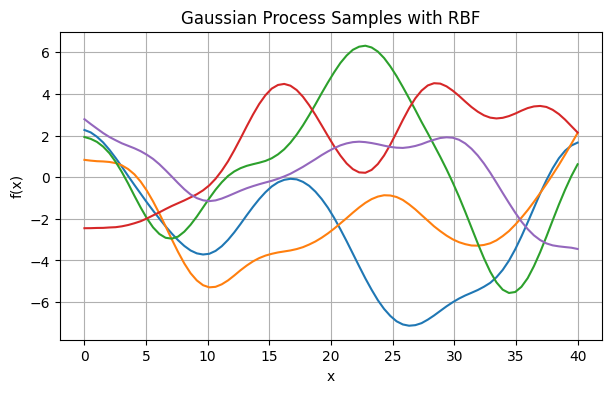

In [ ]:
#@title test
dim=80
x = torch.linspace(0, 40, dim)
# Sample from the GP
samples = dist.MultivariateNormal(loc=0.5*torch.ones(dim), covariance_matrix=gp_kernel()).sample((5,)) # Generate 3 samples

# Step 4: Plot the GP samples
plt.figure(figsize=(7, 4))
for i in range(5):
    plt.plot(x.numpy(), samples[i].numpy(), label=f'Sample {i+1}')

plt.title('Gaussian Process Samples with RBF')
plt.xlabel('x')
plt.ylabel('f(x)')
#plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def build_mask(params_dim=3,funct_dim=80,y_dim=16,obs_idx=obs_idx):
  # posterior mask
  post_mask=np.zeros(params_dim+funct_dim+y_dim)
  arr = np.zeros(funct_dim)
  arr[obs_idx] = 1
  post_mask[params_dim:-y_dim]=arr
  post_mask[-y_dim:]=np.ones(y_dim)
  M=params_dim+funct_dim+y_dim
  #likelihood mask
  like_mask=np.ones(params_dim+funct_dim+y_dim)
  like_mask[-y_dim:]=np.zeros(y_dim)
  return post_mask.astype(int),like_mask.astype(int),M

In [ ]:
 # M =params_dim+funct_dim+y_dim
post_mask,like_mask,M=build_mask()
t,y_true=weeks, spline_values
idx=np.where(post_mask==1)[0]
y_o=np.concatenate([spline_values[obs_idx],np.array(y_obs)[obs_idx]],axis=-1)

In [ ]:
# Set random key
key = jax.random.PRNGKey(3)

In [ ]:
#@title Simulate synthetic data for training ( 20000 simulated samples).

theta, y= simulate_for_sbi(simulator_Model, proposal=prior, num_simulations=10000) # theta== Gaussian Process sample, y= likelihood sample

#np.concatenate((np.array(theta), np.array(y)), axis=1)
data=jnp.array((np.array(torch.cat((theta, y), dim=1).unsqueeze(-1))))
nodes_max = data.shape[1]                       # each variable is consider a node of a graph
node_ids = jnp.arange(nodes_max)                # node Id ( position )
print(f'data shape:{data.shape}')               # (Batch_dim, node_max ,1)


#@title 2) Setting up the diffusion process
# VESDE
T = 1.
T_min = 1e-2
sigma_min = 1e-3
sigma_max = 15.

p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

data shape:(10000, 99, 1)


In [ ]:


# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)




#@title Build the Embedding modules + Transformer architecture

#setup the latent dimensions
dim_value = 20      # Size of the value embedding
dim_id = 20         # Size of the node id embedding
dim_condition = 10  # Size of the condition embedding


def model(t: Array, x: Array, node_ids: Array, condition_mask:Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model.

    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.
    Returns:
        Array: Score estimate of p(x_t)
    """

    batch_size, seq_len, _ = x.shape
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)

    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(64)  # Time embedding method
    time_embeddings = embedding_time(t)

    # Tokinization part --------------------------------------------------------------------------------

    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net ( we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # Node id embedding nets (we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5)) #Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))

    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)

    # Concatenate embeddings (alternatively we can also add instead of concatenating)
    x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)

    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3)

    # Encode -  use a transformer to transform the tokenized inputs into a latent representation
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (we scale the output by the marginal std dev)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out) # SDE dependent output scaling
    return out



#@title  Initialize the model .( as require in Haiku )
# Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument)

init, model_fn= hk.without_apply_rng(hk.transform(model))
params=init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

# view total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters



#@title  The loss function
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey,batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)

    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generator(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids

    # # Condition mask -> randomly condition on some data.
    #condition_mask = jax.random.bernoulli(rng_condition, 0.10, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    # condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    # condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    #condition_mask = condition_mask[..., None]

    #Alternatively  set the condition mask manually to specific conditional distributions.
    #cond= jnp.zeros((80,), dtype=jnp.bool_)  # Joint mask
    cond=jnp.zeros((M),dtype=jnp.bool_).at[idx].set(1) # Posterior mask
    condition_mask= jnp.tile(jnp.expand_dims(cond,axis=0), (batch_xs.shape[0], 1))  # Replicate along the first dimension

    # one can also structure the base mask!
    #edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask

    # Optional: Include marginal consistency
    # marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    # edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    # edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask) #, edge_mask=edge_masks
    return loss





#@title training : designed  to leverage parallel computation on multiple devices  ( GPU )
optimizer = optax.adam(1e-3)        # optimizer
opt_state = optimizer.init(params)  # initial params state

@partial(jax.pmap, axis_name="num_devices")                                 # parallelize computations
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)                  # compute loss and gradients

    loss = jax.lax.pmean(loss, axis_name="num_devices")                     # aggregate loss accross devices ( mean )
    grads = jax.lax.pmean(grads, axis_name="num_devices")                   # aggregate gradients accross devices ( mean )

    updates, opt_state = optimizer.update(grads, opt_state, params=params)  #
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state



#title replicate the model params and optimizer state across available devices for data-parallel computation
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)


Total number of parameters:  47694


In [ ]:
#@title define data generator:
def generator(key: PRNGKey, n:int):
    key1,key2= jrandom.split(key,2)
    theta, y = simulate_for_sbi(simulator_Model, proposal=prior, num_simulations=n)
    return jnp.array((np.array(torch.cat((theta, y), dim=1).unsqueeze(-1))))

In [ ]:
#@title training loop
start_time=time.time()
key = jrandom.PRNGKey(2)
train_loss=[]
epochs=15
for epoch in range(epochs):
    l = 0
    for i in range(5000):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey,  (n_devices,)), replicated_opt_state)
        l += loss[0] /5000
    train_loss.append(l)
    #if epoch % 10==0:
    print(f"Epoch: {epoch} | Loss: {l}")
end_time=time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.4f} seconds")

#get updated params (tree object ) for inference
params= jax.tree_map(lambda x: x[0], replicated_params)

Running 1024 simulations.:   0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Epoch: 0 | Loss: 828.1978149414062
Epoch: 1 | Loss: 693.1092529296875
Epoch: 2 | Loss: 659.5274658203125
Epoch: 3 | Loss: 633.9403076171875
Epoch: 4 | Loss: 614.5276489257812
Epoch: 5 | Loss: 601.8698120117188
Epoch: 6 | Loss: 592.5477294921875
Epoch: 7 | Loss: 583.4594116210938
Epoch: 8 | Loss: 576.4034423828125
Epoch: 9 | Loss: 568.8601684570312
Epoch: 10 | Loss: 563.411376953125
Epoch: 11 | Loss: 557.6004028320312
Epoch: 12 | Loss: 553.2455444335938
Epoch: 13 | Loss: 548.8363037109375
Epoch: 14 | Loss: 545.1661376953125
Running time: 3510.3923 seconds


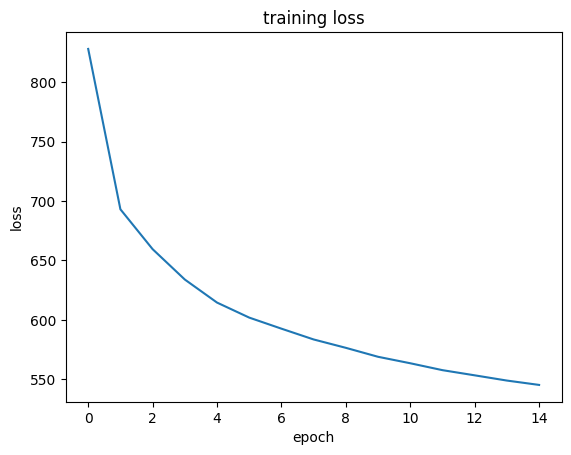

In [ ]:
def training_history(train_loss):
  plt.plot(np.arange(len(train_loss)),np.array(train_loss))
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("training loss")

training_history(train_loss)

In [ ]:
import pickle
with open('tree_params_SIER4_6rho_10I.pkl', 'wb') as f: # first exp: 40 GP dim=20 , obs=20,
    pickle.dump(params, f)

In [ ]:
#@title Sampling  process

from functools import partial
from probjax.utils.sdeint import sdeint

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])

    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x)
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]

    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys

In [ ]:
#@title plotting function

def mean_pred(samples,y_true,x_obs,y_obs):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  plt.plot(t, y_true, label="ground truth", color="orange")
  plt.scatter(x_obs, y_obs, color="red", label="observed ", s=60)
  plt.plot(t, mean_post_pred, label="predicted mean")
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(t, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.legend(fontsize=6)

def median_pred(samples,y_true,x_obs,y_obs,title="inferred mean",labels=False):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
  plt.plot(t,y_true, label="ground truth", color="orange")
  plt.scatter(x_obs,y_obs, marker='x', color="black", label="observed $\\rho$", s=40)
  plt.plot(t, mean_post_pred, label="predicted mean")
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(t, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.ylim([0, 2])
  #plt.xticks([])  # Removes x-axis ticks
  #plt.yticks([])  # Removes y-axis ticks
  plt.title(title)
  plt.xlabel('time (weeks)')
  if labels==True:
      plt.yticks()
      plt.ylabel('$\\rho(t)$')
  #plt.legend()
  #plt.tight_layout()  # Adjust layout to fit everything nicely
  plt.grid()
  plt.legend(fontsize=7)

In [ ]:
t.shape

(80,)

#Inference

In [ ]:
#@title  time-varying parameter rho
import time
# Inferred time-varying transmission
def Inference(idx,y_true,n_samples=5000,title="Inferred time-varying transmission",labels=True,draws=False,num_obs=16):
    start_time = time.time()
    cond_stat=jnp.zeros((M),dtype=jnp.bool_).at[idx].set(1) # mask for targeting the posterior
    y=jnp.zeros((M)).at[idx].set(y_o) # observed values ( conditioned )
    samples = sample_fn(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
    rho=samples[...,-1,3:-num_obs]
    theta=samples[...,-1,:3]
    #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
    median_pred(rho,y_true,t[obs_idx],y_true[obs_idx],title=title,labels=labels)
    end_time = time.time()
    # Calculate the running time
    elapsed_time = end_time - start_time
    print(" ")
    print(f"inference time: {elapsed_time} sec , for {n_samples} samples")
    return theta,rho

 
inference time: 41.802188873291016 sec , for 5000 samples


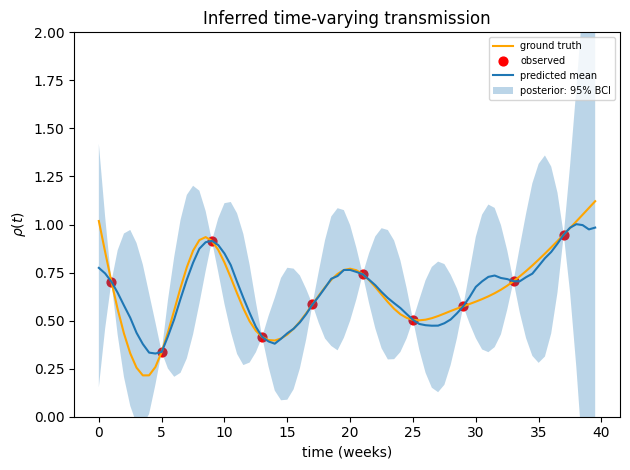

In [ ]:
posterior_samples,rho=Inference(idx,y_true)

In [ ]:
#@title Posterior predictive

def posterior_pred(theta):
  beta=0.26 #theta[0]
  gamma=theta[1] #0.2 #
  tau=theta[2] #0.3
  rho=theta[3:]
  I= sier_Model(beta, gamma,tau,rho)
  I_vals=torch.nan_to_num(torch.clamp(I, min=0, max=max_pop), nan=0.0)
  I_obs=dist.NegativeBinomial(total_count=I_vals, probs=0.51).sample()
  return I_obs   #[obs_idx].unsqueeze(0) #.unsqueeze(0)

def plotter_pred(n_samples=100,num_obs=16):
  cond_stat=jnp.zeros((M),dtype=jnp.bool_).at[idx].set(1) # mask for targeting the posterior
  y=jnp.zeros((M)).at[idx].set(y_o) # observed values ( conditioned )
  samples = sample_fn(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
  post_samples=samples[...,-1,0:-num_obs]
  predictions=[]

  for row in torch.tensor(np.array( post_samples)):
    pred=posterior_pred(row)
    predictions.append(pred)


  predictions=np.array(predictions)

  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)


  plt.plot(t, I_vals.numpy(), label='ground truth I(t)', color='red')
  #plt.plot(time_array.numpy(), R_vals.numpy(), label='Recovered', color='green')
  plt.scatter(t[obs_idx], y_obs.numpy()[obs_idx], marker='x', label='observed cases', color='black')
  plt.plot(t, mean_post_pred, label="posterior predictive mean")

  #plt.legend()
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(t, percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="posterior: 95% BCI")
  plt.xlabel('time (weeks)')
  plt.ylabel('Numbers of cases')
  plt.title('predited trajectory $I(t)$')
  plt.legend(fontsize=7)

  plt.grid()
  plt.show()

In [ ]:
#@title marginal posterior function (kde): Inferred non functional params (beta, gamma, tau)
def marginal_posterior_kde():
  theta_o=torch.tensor([0.25,0.2,0.3]).unsqueeze(0)
  fig, ax = analysis.pairplot(
  samples=posterior_samples,
   limits=[[0,1],[0,1],[0,1]],
    upper=["kde"],
    diag=["kde"],
    figsize=(7, 4),
     points=theta_o,
    fig_kwargs={
        "points_labels":[r"$\theta_0$"],
        "legend":True,
        "points_colors": ["red"],
        "points_offdiag": {"marker": "+", "markersize": 20},
        "despine": {"offset": 0},
    },
    labels=[r"$\beta$", r"$\gamma$", r"$\tau$"],
   )


 
inference time: 3.628098964691162 sec , for 500 samples


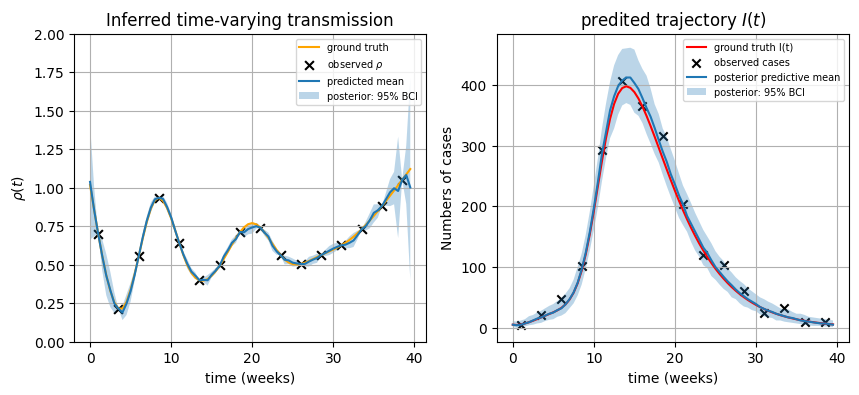

In [ ]:
#@title 16 observed infer only the time-varying transmission rate
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1, 2, 1)
posterior_samples,rho=Inference(idx,y_true,n_samples=500)
fig.add_subplot(1, 2, 2)
plotter_pred(n_samples=500)

 
inference time: 42.435733795166016 sec , for 5000 samples


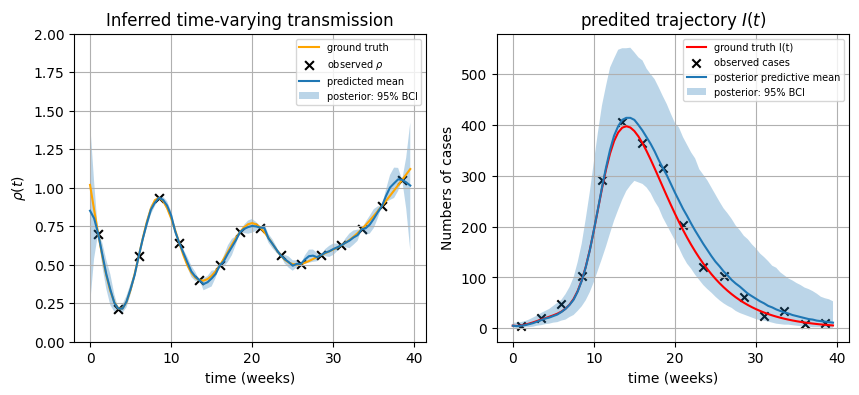

In [ ]:
#@title 16 observed infer only the time-varying transmission rate & time-invariant parameters.
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1, 2, 1)
posterior_samples,rho=Inference(idx,y_true,n_samples=5000)
fig.add_subplot(1, 2, 2)
plotter_pred(n_samples=5000)

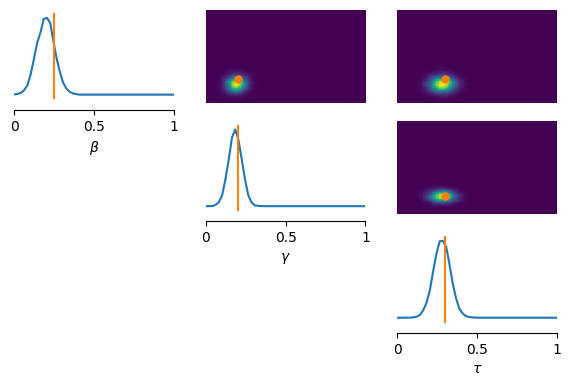

In [ ]:
marginal_posterior_kde()

In [ ]:
#@title Full Marginal posterior

def estimate_map(samples):

    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i

def plot_posteriors_state( n_samples=5000, figsize=(8, 3), dpi=150,
                          font_size=12, bins=30, map_samples=500, filename=None):
    """Plots full posteriors for each state."""

    # Plot settings
    plt.rcParams['font.size'] = font_size


    prior_samples=np.array(prior.sample((n_samples,))[:,0:3])
    samples = np.array(posterior_samples)


    f, ax = plt.subplots(1, 3, figsize=figsize)
    for i in range(samples.shape[1]):


        sns.histplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior')
        sns.histplot(prior_samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='gray',label='Prior', alpha=0.3)

        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(true_params[i], color='black', linestyle='dashed',label=param_id[i]) # true_params[i]
        ax.flat[i].set_title(param_names_str[i] + ' (' + param_names[i] + ')', pad=6, fontsize=14)
        ax.flat[i].set_ylim([0, ax.flat[i].get_ylim()[1]])

        align = 'left'
        xx = 0.73
        med = np.median(samples[:, i])
        MAP = estimate_map(samples[:map_samples, i])
        ax.flat[i].text(xx, 0.85, r'$MAP={:.2f}$'.format(MAP),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        ax.flat[i].text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)

        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])

    f.tight_layout()
    f.subplots_adjust(bottom=0.07)
    ax.flat[samples.shape[1]-1].legend(fontsize='small')
     # Save if specified
    # if filename is not None:
    #     f.savefig("figures/{}.png".format(filename), dpi=dpi,
    #               bbox_extra_artists=(lg,), bbox_inches='tight')
    return f
param_names_str = ['transmission probability','recovery rate','1/average latent period']
param_names=['$\\beta$','$\gamma$','$\\tau$']
param_id=['true $\\beta$','true $\gamma$','true val']
true_params = np.array([0.25,0.2,0.3])

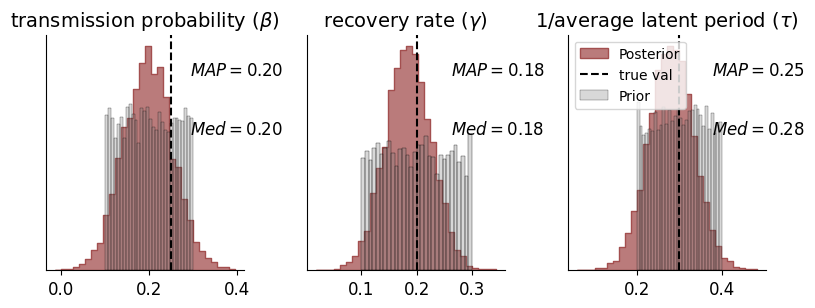

In [ ]:
fig=plot_posteriors_state()

 
inference time: 41.43232345581055 sec , for 5000 samples


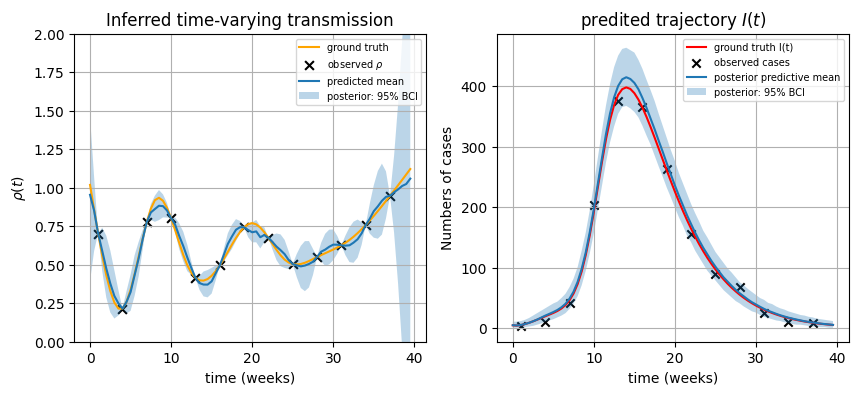

In [ ]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1, 2, 1)
posterior_samples,rho=Inference(idx,y_true,n_samples=10)
fig.add_subplot(1, 2, 2)
plotter_pred(n_samples=10)

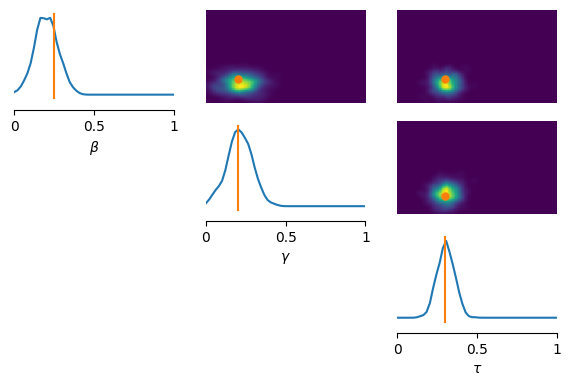

In [ ]:
marginal_posterior_kde()

In [ ]:
fig.savefig('SIER_exp1_fig6.pdf')
fig.savefig('SIER_exp1_fig6.svg')
fig.savefig('SIER_exp1_fig6.png')

In [ ]:
#@title GP priors vs Posterior samples
def median_pred2(samples,prior_samples,title=None,labels=True,draws=True,n=50):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
# prior samples
  p_samples=np.array(prior_samples)
  p_percentiles = np.percentile(p_samples, [5.0, 95.0], axis=0)

  #plt.plot(x, np.array(y_true), label="ground truth (RBF)", color="orange")
  #plt.scatter(x_obs, np.array(y_obs), color="red", label="observed", s=40)
  #plt.plot(x, mean_post_pred, label="predicted mean",alpha=1)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(t, percentiles[0, :], percentiles[1, :], alpha=0.4, interpolate=True, label="posterior: 95% BCI",color='blue')
  plt.fill_between(t, p_percentiles[0, :],p_percentiles[1, :], alpha=0.2, interpolate=True, label="prior: 95% BCI",color='grey')
  if draws==True:
        # Randomly select 'n' row vectors and plot them
    selected_indices = np.random.choice(predictions.shape[0], n, replace=False)
    for i, idx in enumerate(selected_indices):
        #if i == 0:
              # Add label only for the first line
            plt.plot(t, predictions[idx], color='green', alpha=0.2, )
            plt.plot(t, p_samples[idx], color='gray', alpha=0.3)
    plt.plot(t, predictions[idx], color='green', alpha=0.2, label="Posterior draws")
    plt.plot(t, p_samples[idx], color='gray', alpha=0.3, label="Prior draws")


  #plt.xlim([0, 1])
  #plt.xticks([])  # Removes x-axis ticks
  #plt.yticks([])  # Removes y-axis ticks
  if title!=None:
    plt.title(title)
  if labels==True:
      plt.xlabel('t')
      plt.ylabel('$\\rho(t)$')
  #plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely
  plt.legend(fontsize=7)


posterior_samples,rho=Inference(idx,y_true)
p_samples = dist.MultivariateNormal(loc=0.5*torch.ones(dim), covariance_matrix=gp_kernel()).sample((5000,))

In [ ]:
fig = plt.figure(figsize=(5,4))
median_pred2(rho,p_samples,title='prior vs posterior',labels=True,draws=True)

In [ ]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(1, 3, 1)
median_pred2(rho,p_samples,title='prior vs posterior',labels=True,draws=True)
fig.add_subplot(1, 3, 2)
posterior_samples,_=Inference(idx,y_true,n_samples=5000)
fig.add_subplot(1, 3, 3)
plotter_pred(n_samples=5000)